# GMM Gym

Minimal working example of a GMM!

## 1. Setup

+ 1.1 Set up real deep parameters ($\lambda_0 = f(X, \theta)$)
+ 1.2 Get ValueF and optimal policy function
+ 1.3 Simulate demand and optimal pricing for N firms

## 2. Estimating $\theta$

Try $\theta$ until error < $\varepsilon$

+ 2.1. $\theta$ values generate a $\lambda_0$
+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions
+ 2.3. $error = \left|pricing decisions - observed pricing\right|$


## 1. Setup

In [1]:
import numpy as np
from typing import Callable
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
    
import sys
sys.path.append('../')
import src

# Simulation parameters \
########################
σerror= 0.005 #0.01
Nfirms = 300
time_periods = 40
β10, β11 = 0.1, 2
β20, β21 = 0.3, -1

#TODO: consider using an e**x transformation to avoid clipping
def lambda_0v0(x) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    lambda1 = np.clip(β10 + β11*x + np.random.normal(0, σerror), 0, 1)
    lambda2 = np.clip(β20 + β21*x + np.random.normal(0, σerror), 0, 1)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

def from_theta_to_lamba0v0(θ, x):
    """
    Generates a lambda0 vector from the theta vector and x
    θ = [θ10, θ11, θ20, θ21]
    """
    lambda1 = np.clip(θ[0] + θ[1]*x + np.random.normal(0, σerror), 0, 1)
    lambda2 = np.clip(θ[2] + θ[3]*x + np.random.normal(0, σerror), 0, 1)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

#Suitable for logistic
β10, β11 = -2, 3
β20, β21 = 0.03, -2.

def logistic(x):
    return 1/(1+np.e**(-x))

def lambda_0(x) -> np.ndarray:
    """
    Generate a vector of lambdas on the observables x
    """
    lambda1 = logistic(β10 + β11*x + np.random.normal(0, σerror))
    maxlambda2_value = 1 - lambda1
    lambda2 = np.clip(logistic(β20 + β21*x + np.random.normal(0, σerror)), 0, maxlambda2_value)
    lambda3 = 1 - lambda1 - lambda2
    return np.array([lambda1, lambda2, lambda3])

def from_theta_to_lamba0(θ, x):
    """
    Generates a lambda0 vector from the theta vector and x
    θ = [θ10, θ11, θ20, θ21]
    """
    lambda1 = logistic(θ[0] + θ[1]*x + np.random.normal(0, σerror))
    maxlambda2_value = 1 - lambda1
    lambda2 = np.clip(logistic(θ[2] + θ[3]*x + np.random.normal(0, σerror)), 0, maxlambda2_value)
    lambda3 = logistic(1 - lambda1 - lambda2)
    return np.array([lambda1, lambda2, lambda3])



def get_lambdas_from_x(xs):
    y = np.empty((len(xs), 3))
    for i in range(len(xs)):
        y[i] = lambda_0(xs[i])
    return y

xs = np.abs(np.random.normal(0, 0.18, size=Nfirms))
lambdas0 = get_lambdas_from_x(xs)
lambdas0[0:10]



array([[0.16994789, 0.43637014, 0.39368197],
       [0.24265349, 0.36428628, 0.39306023],
       [0.20348387, 0.40311542, 0.39340072],
       [0.21614112, 0.39087477, 0.39298411],
       [0.13719562, 0.48111603, 0.38168835],
       [0.13671401, 0.48139322, 0.38189277],
       [0.30441464, 0.32061145, 0.37497391],
       [0.18182337, 0.4278981 , 0.39027854],
       [0.15061486, 0.46202574, 0.3873594 ],
       [0.18493539, 0.42237627, 0.39268834]])

In [2]:
file_n = "2018-10-5vfi_dict.dill"
with open('../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


In [3]:


def many_runs(nfirms, **kwargs):
    dfs = []
    for firm_i in range(nfirms):
        df = src.simulate_one_firm(valueF, policyF,
                                   maxt=time_periods,
                                   lambda0=lambdas0[firm_i], **kwargs)
        df['firm'] = firm_i
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)


df = many_runs(Nfirms)

## Estimating $\theta$

+ 2.1. $\theta$ values generate a $\lambda_0$

(defined aboved)

+ 2.2. $\lambda_0$ + demand observations + optimal pricing generate pricing decisions

In [5]:

src.generate_pricing_decisions(policyF, np.array([0.2, 0.6, 0.2]),
                               df[df.firm == 15].log_dmd.values)[0:4]

array([2.32068966, 1.48614406, 1.57204123, 1.25878561])

+ 2.3. $error = \left|pricing decisions - observed pricing\right|$

+ Do I choose moments?

In [39]:
df.head(3)

,t,level_prices,log_dmd,valueF,lambda1,lambda2,lambda3,firm
t,,,,,,,,
0,0,2.396552,0.154452,18.485303,1.699479e-01,0.436370,0.393682,0
1,1,2.424762,0.000577,18.445762,2.420931e-07,0.346518,0.653482,0
2,2,2.586207,-0.339324,19.043531,6.797426e-13,0.242494,0.757506,0


In [40]:
#Generate running std (to start)
std_firm = (df.groupby('firm').level_prices.rolling(window=4, min=3,
                                                    on=df['t'])
             .std().reset_index())
std_firm

ValueError: invalid on specified as t
0         0
1         1
2         2
3         3
4         4
5         5
6         6
7         7
8         8
9         9
10       10
11       11
12       12
13       13
14       14
15       15
16       16
17       17
18       18
19       19
20       20
21       21
22       22
23       23
24       24
25       25
26       26
27       27
28       28
29       29
         ..
11970    10
11971    11
11972    12
11973    13
11974    14
11975    15
11976    16
11977    17
11978    18
11979    19
11980    20
11981    21
11982    22
11983    23
11984    24
11985    25
11986    26
11987    27
11988    28
11989    29
11990    30
11991    31
11992    32
11993    33
11994    34
11995    35
11996    36
11997    37
11998    38
11999    39
Name: t, Length: 12000, dtype: int64, must be a column (if DataFrame) or None

In [27]:
std_firm.index.names

FrozenList(['firm', None])

1.2999150967298112 1.2869394664881244 1.1539347845185266


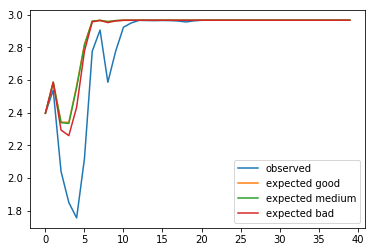

In [136]:
def error(θ: np.ndarray, x, observed_log_dmd, observed_prices) -> float:
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return np.linalg.norm(expected_prices - observed_prices)


firm_id = 90
chosen_x = xs[firm_id]
chosen_dmd = df[df.firm == firm_id].log_dmd.values
chosen_prices = df[df.firm == firm_id].level_prices.values


def error_diagnostic(θ, x, observed_log_dmd, observed_prices):
    lambda0 = from_theta_to_lamba0(θ, x)
    expected_prices = generate_pricing_decisions(lambda0, observed_log_dmd)
    return observed_prices, expected_prices, np.linalg.norm(expected_prices - observed_prices)

def error_w_data(θ) -> float:
    return error(θ, chosen_x, chosen_dmd, chosen_prices)


trueθ0 = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+0.3, β11-0.05, β20+0.1, β21-0.05])
obs_pr, exp_pr, norm1 = error_diagnostic(trueθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prmedium, exp_prmedium, norm2 = error_diagnostic(mediumθ0, chosen_x, chosen_dmd, chosen_prices)
obs_prbad, exp_prbad, norm3 = error_diagnostic(badθ0, chosen_x, chosen_dmd, chosen_prices)

print(norm1, norm2, norm3)
fig, ax = plt.subplots(1, 1)
ax.plot(obs_pr, label='observed')
ax.plot(exp_pr, label="expected good")
ax.plot(exp_prmedium, label="expected medium")
ax.plot(exp_prbad, label="expected bad")
ax.legend();

## 3. Optimize

## Nelder-Mead

Doesn't converge. Not super surprised, since the problem is weird

In [141]:
from scipy import optimize as opt
#minimize(f, x0,, method='Nelder-Mead')
true_params = np.array([β10, β11, β20, β21])
mediumθ0 = np.array([β10+0.1, β11-0.1, β20+0.01, β21-0.01])
badθ0 = np.array([β10+2, β11-1, β20+1, β21-3])
opt.minimize(error_w_data, badθ0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})

 final_simplex: (array([[ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00],
       [ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00,
        -4.99999927e+00]]), array([1.91533241, 1.9243984 , 1.9332215 , 1.93347883, 1.93582771]))
           fun: 1.9153324053720298
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 13571
           nit: 5000
        status: 2
       success: False
             x: array([ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00, -4.99999927e+00])

In [143]:
true_params - badθ0

array([-2.,  1., -1.,  3.])

In [142]:
true_params - np.array([ 1.23357625e-09,  1.99999990e+00,  1.03000024e+00, -4.99999927e+00])

array([-2.        ,  1.0000001 , -1.00000024,  2.99999927])

In [138]:
true_params

array([-2.  ,  3.  ,  0.03, -2.  ])

In [139]:
mediumθ0

array([-1.9 ,  2.9 ,  0.04, -2.01])

In [140]:
badθ0 

array([-1.7 ,  2.95,  0.13, -2.05])

## Differential Evolution

Does converge! Seems promising even though it's slow

In [144]:
opt.differential_evolution(error_w_data, [(-3, 3), (-3, 3), (-3, 3), (-3, 3)],
                          maxiter=1000)

     fun: 0.048427970155213274
 message: 'Optimization terminated successfully.'
    nfev: 7965
     nit: 130
 success: True
       x: array([-1.36566532,  0.48591431,  0.67631488, -2.59839081])